In [1]:
import os

datapath = os.getcwd()+'\\data'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
TrainData = pd.read_csv(datapath + '\\train.csv')
ValData = pd.read_csv(datapath + '\\val.csv')
TestData = pd.read_csv(datapath + '\\test.csv')

In [4]:
import math

root = len(TrainData.drop(columns=['ID']).columns)**0.5
nrows = math.floor(root)
ncols = math.ceil(root)

arr = np.ones((nrows, ncols))

-----------------------------------------------

0.11.2


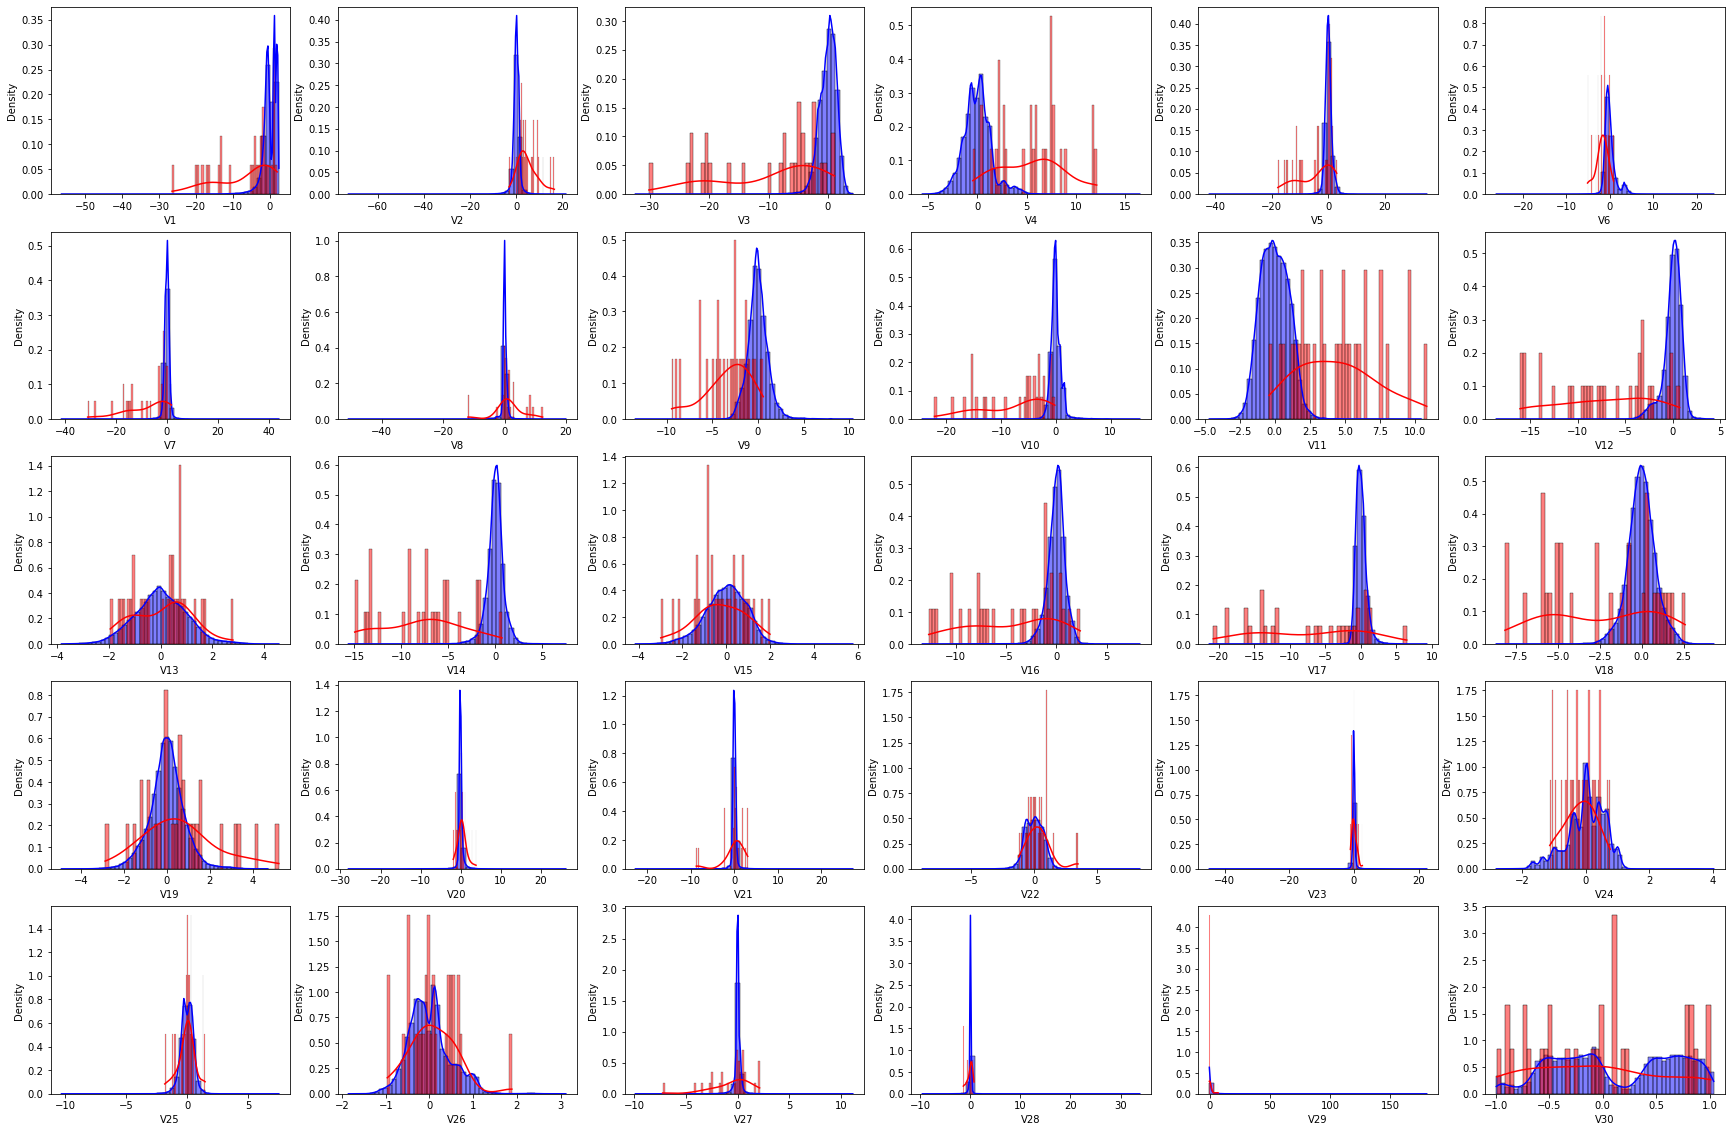

In [6]:
i = []
j = []

for (row,col),x in np.ndenumerate(arr) :
    i = i + [row]
    j = j + [col]

#확률밀도비교
#sharex (True일 경우 X축 공유)
import seaborn as sns

print(sns.__version__)

f, axes = plt.subplots(nrows,ncols, figsize=(30,20))

for col, i, j in zip(TrainData.drop(columns=['ID']).columns,i,j) :
    sns.histplot(TrainData[col],ax = axes[i,j], stat = 'density', bins= 50, color = 'blue',kde=True, kde_kws = {'bw_adjust': 1})
    sns.histplot(ValData[ValData['Class']==1][col],ax = axes[i,j], stat = 'density', bins= 50, color = 'red',kde=True, kde_kws = {'bw_adjust': 1})
                 
plt.show()

사기탐지됨 플롯의 확률 밀도를 가져와보자

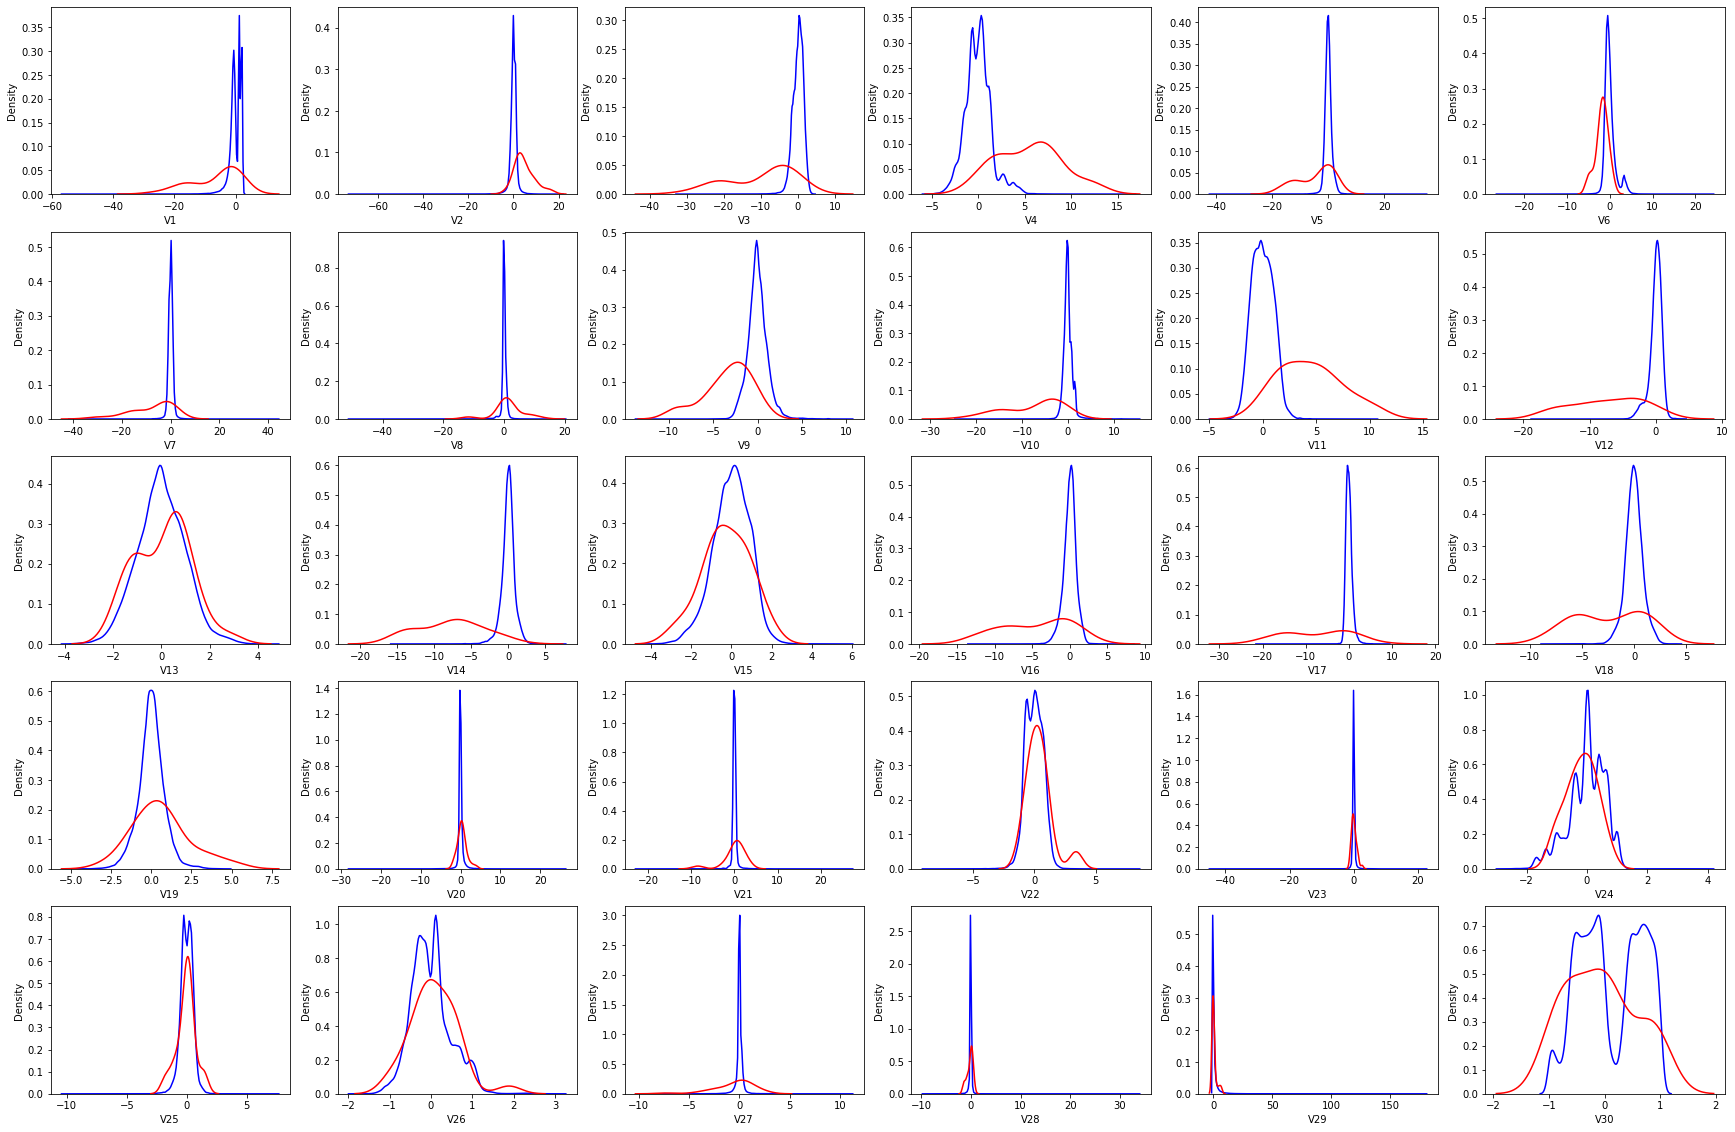

In [6]:
i = []
j = []

for (row,col),x in np.ndenumerate(arr) :
    i = i + [row]
    j = j + [col]

#확률밀도비교
#sharex (True일 경우 X축 공유)
import seaborn as sns

f, axes = plt.subplots(nrows,ncols, figsize=(30,20))

for col, i, j in zip(TrainData.drop(columns=['ID']).columns,i,j) :
    sns.kdeplot(TrainData[col],ax = axes[i,j], color = 'blue')
    sns.kdeplot(ValData[ValData['Class']==1][col],ax = axes[i,j], color = 'red')
                 
plt.show()

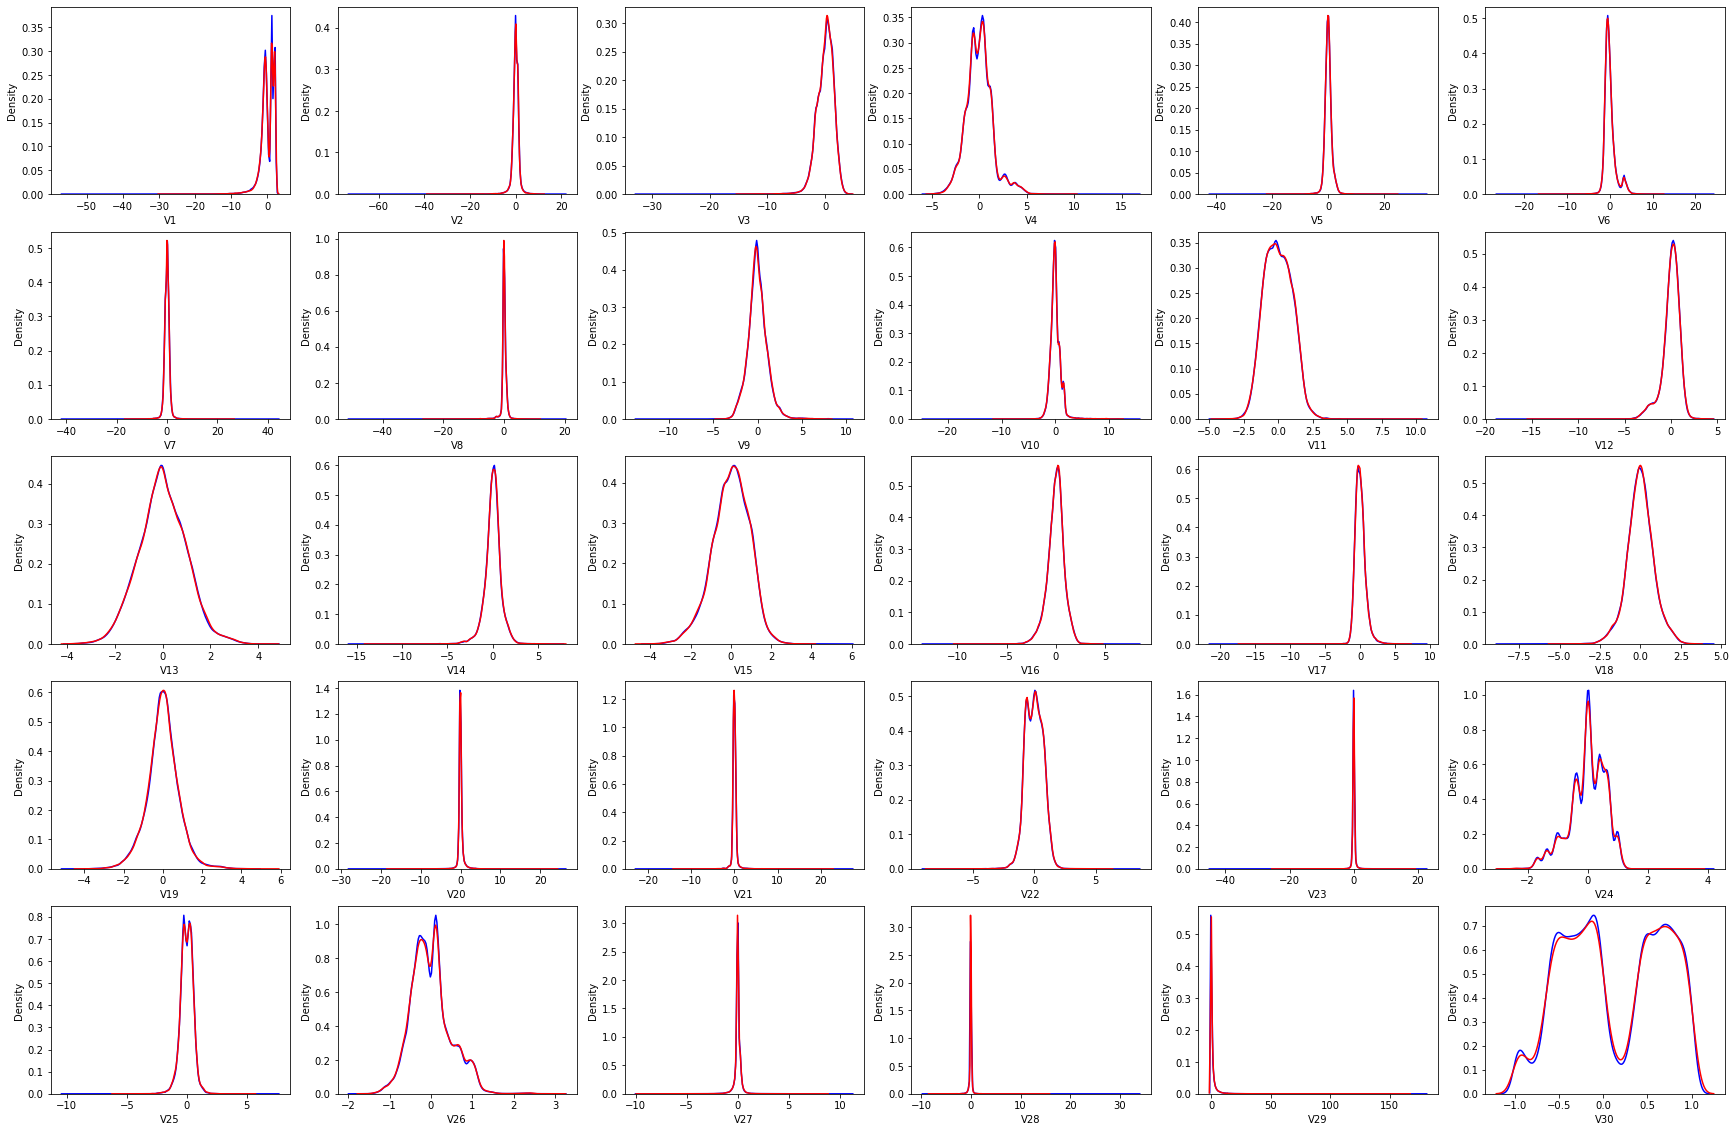

In [34]:
i = []
j = []

for (row,col),x in np.ndenumerate(arr) :
    i = i + [row]
    j = j + [col]

#확률밀도비교
#sharex (True일 경우 X축 공유)
import seaborn as sns

f, axes = plt.subplots(nrows,ncols, figsize=(30,20))

for col, i, j in zip(TrainData.drop(columns=['ID']).columns,i,j) :
    sns.kdeplot(TrainData[col],ax = axes[i,j], color = 'blue')
    sns.kdeplot(ValData[ValData['Class']==0][col],ax = axes[i,j], color = 'red')
                 
plt.show()

In [9]:
#scipy.stats.gaussian_kde 커널을 찾는자

# https://stackoverflow.com/questions/68396403/kernel-density-estimation-using-scipys-gaussian-kde-and-sklearns-kerneldensity
#from scipy.stats import gaussian_kde

# eval_points = np.linspace(np.min(x), np.max(x))
# kde_sp = gaussian_kde(x, bw_method=0.25)
# y_sp = kde_sp.pdf(eval_points)

In [11]:
# from scipy.stats import gaussian_kde

# v1_data = ValData[ValData['Class']==1]['V3']

# kde_sp = gaussian_kde(v1_data,bw_method=0.16) #'silverman' #0.16이 가장 괜찮음
# print(kde_sp.factor)
# #최적 bw = 1.06*std*(n)**(-0.2) #siverman은 아님

# eval_points = np.linspace(np.min(v1_data), np.max(v1_data))

# print([kde_sp.integrate_box_1d(-np.Inf,x) for x in eval_points][-1]) #cdf 마지막 값

# plt.plot(eval_points, kde_sp.pdf(eval_points))

0.16
0.9586228821400884


In [180]:
# pdf기반으로 각 값의 확률을 탐색

In [5]:
from scipy.stats import gaussian_kde

#고장 KDE

cols = TrainData.columns[1:]

train_pdf = pd.DataFrame()

for col in cols :
    v_data = ValData[ValData['Class']==1][col]
    kde_sp = gaussian_kde(v_data,bw_method=0.16)
    
    pdf_V = kde_sp.pdf(TrainData[col])
    pdf_V = pd.DataFrame(pdf_V,columns=[col])
    
    train_pdf = pd.concat([train_pdf,pdf_V], axis = 1)
    

In [12]:
val_pdf = pd.DataFrame()

#사기일 KDF

for col in cols :
    v_data = ValData[ValData['Class']==1][col]
    kde_sp = gaussian_kde(v_data,bw_method=0.16)
    
    pdf_V = kde_sp.pdf(ValData[col])
    pdf_V = pd.DataFrame(pdf_V,columns=[col])
    
    val_pdf = pd.concat([val_pdf,pdf_V], axis = 1)

In [52]:
val_pdf_zero = pd.DataFrame()

#사기가 아닐 KDF

for col in cols :
    v_data = ValData[ValData['Class']==0][col]
    kde_sp = gaussian_kde(v_data,bw_method=0.16)
    
    pdf_V = kde_sp.pdf(ValData[col])
    pdf_V = pd.DataFrame(pdf_V,columns=[col])
    
    val_pdf_zero = pd.concat([val_pdf_zero,pdf_V], axis = 1)

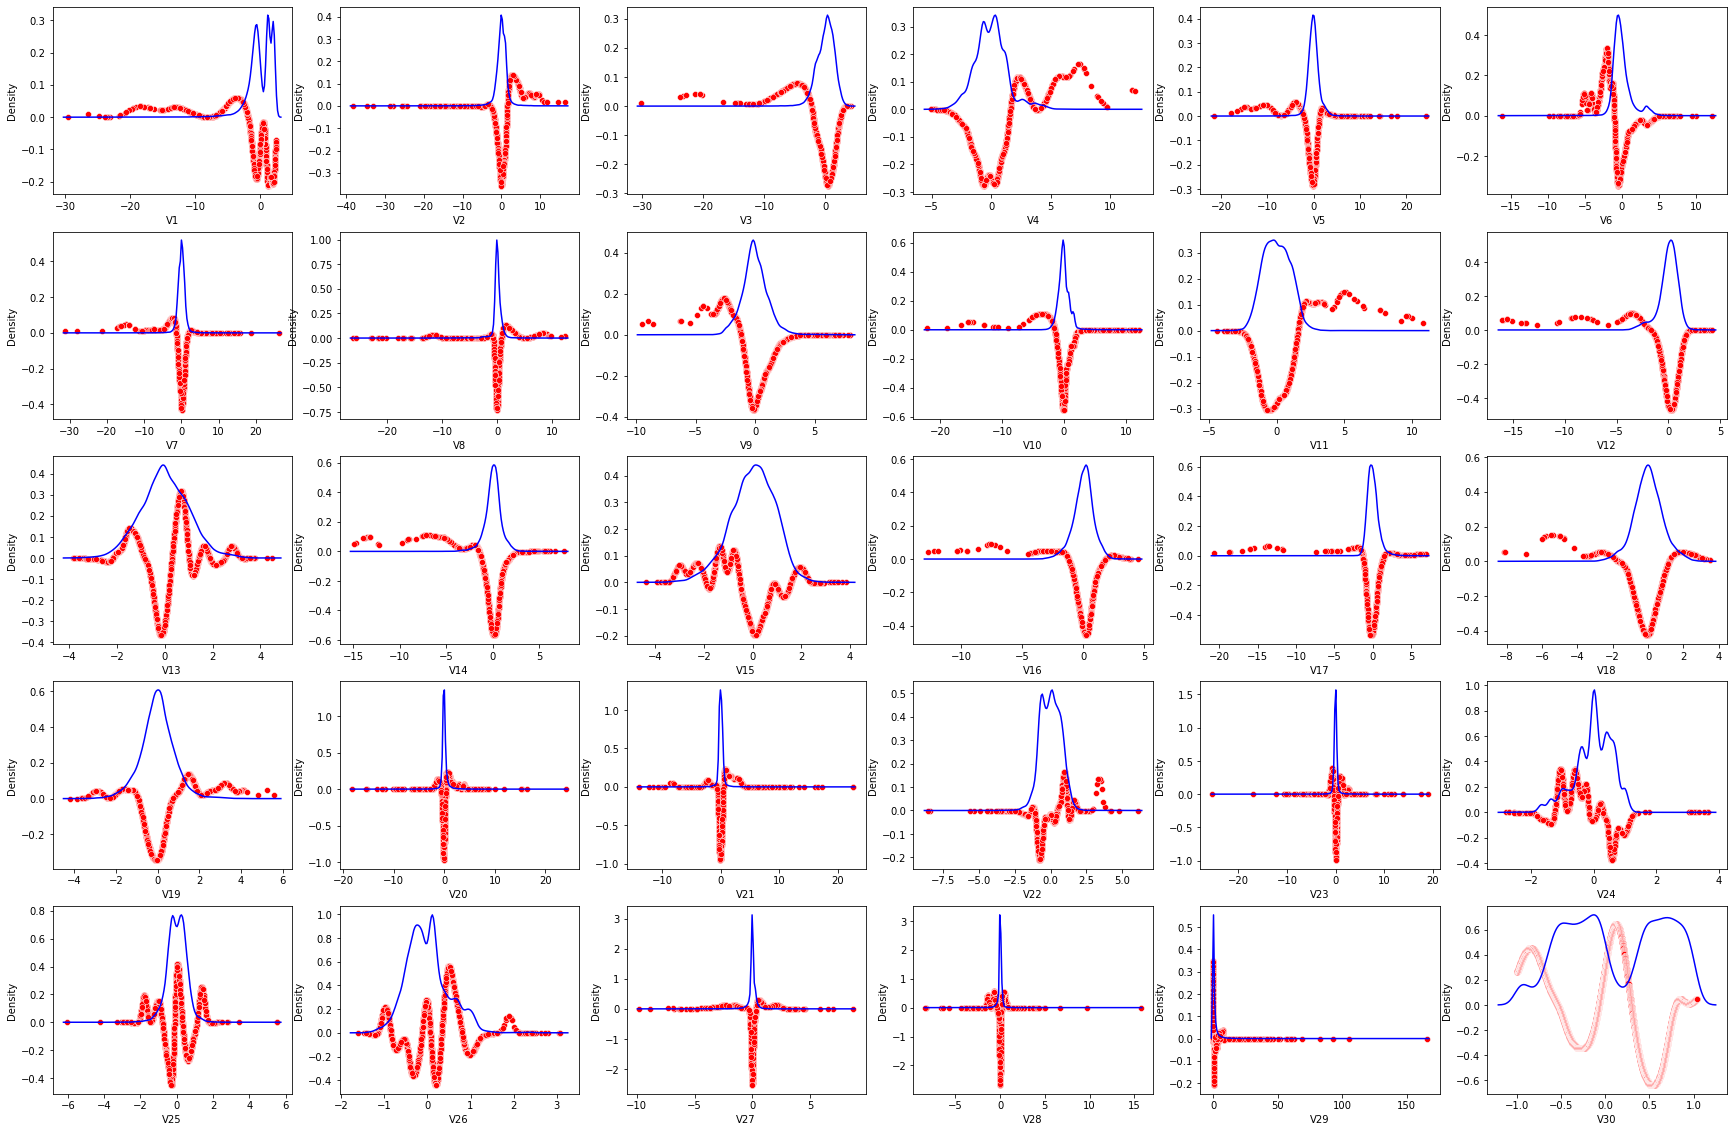

In [109]:
i = []
j = []

for (row,col),x in np.ndenumerate(arr) :
    i = i + [row]
    j = j + [col]

#확률밀도비교
#sharex (True일 경우 X축 공유)
import seaborn as sns

f, axes = plt.subplots(nrows,ncols, figsize=(30,20))

for col, i, j in zip(ValData.drop(columns=['ID','Class']).columns,i,j) :
    sns.kdeplot(ValData[col],ax = axes[i,j], color = 'blue')
    sns.scatterplot(x=ValData[col],y=val_pdf[col]-val_pdf_zero[col], ax = axes[i,j], color = 'red')
                 
plt.show()

In [114]:
# mult_vpdf= val_pdf.T.prod()*10**19

score = val_pdf-val_pdf_zero
#score[score<=0]=0 #sum
#score[score<=0]=1 #prod

v_score = score.T.sum()

In [115]:
v_score = pd.DataFrame(v_score,columns=['score'])
score_class = pd.concat([ValData,v_score],axis=1)

In [118]:
score_class = score_class.sort_values(by='score', ascending=False).reset_index(drop=True)

In [119]:
print(len(v_data))
score_class[score_class['Class']==1]

28432


,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,V29,V30,Class,score
0,12109,-16.917468,9.669900,-23.736443,11.824990,-9.830548,-2.514829,-17.290657,1.820408,-6.264903,...,1.241866,-1.051086,0.038009,0.672317,2.108471,-1.421243,-0.293440,-0.747730,1,4.151506
1,12071,-16.367923,9.223692,-23.270631,11.844777,-9.462037,-2.450444,-16.925152,1.384208,-6.287736,...,1.188212,-1.047184,-0.035573,0.664900,2.122796,-1.416741,-0.293440,-0.749081,1,4.135289
2,150680,-12.833631,7.508790,-20.491952,7.465780,-11.575304,-5.140999,-14.020564,8.332120,-4.337713,...,-0.766495,0.431261,-0.104975,-0.010091,-2.400811,-0.720557,1.146231,0.107931,1,3.879326
3,150681,-12.833631,7.508790,-20.491952,7.465780,-11.575304,-5.140999,-14.020564,8.332120,-4.337713,...,-0.766495,0.431261,-0.104975,-0.010091,-2.400811,-0.720557,1.146231,0.107931,1,3.879326
4,8336,-1.426623,4.141986,-9.804103,6.666273,-4.749527,-2.073129,-10.089931,2.791345,-3.249516,...,0.605809,-0.769348,-1.746337,0.502040,1.977258,0.711607,-0.293440,-0.864214,1,3.628137
5,30443,-3.896583,4.518355,-4.454027,5.547453,-4.121459,-1.163407,-6.805053,2.928356,-4.917130,...,-0.151104,0.011007,0.080303,0.412191,0.635789,0.501050,-0.243695,-0.572916,1,3.314315
6,153824,-19.641857,14.706335,-22.801238,12.114672,-14.898113,0.840778,-28.011293,-11.919639,-8.960922,...,2.585212,0.195009,-1.194803,0.038423,-4.126746,-0.645329,-0.275554,0.182462,1,3.190049
7,151010,-26.457745,16.497472,-30.177317,8.904157,-17.892600,-1.227904,-31.197329,-11.438920,-9.462573,...,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,-0.293440,0.113606,1,2.813607
8,6339,0.316459,3.809076,-5.615159,6.047445,1.554026,-2.651353,-0.746579,0.055586,-2.678679,...,-0.583813,-0.219845,1.474753,0.491192,0.518868,0.402528,-0.293440,-0.906272,1,2.501333
9,150668,-10.850282,6.727466,-16.760583,8.425832,-10.252697,-4.192171,-14.077086,7.168288,-3.683242,...,-1.023967,0.406265,0.106593,-0.026232,-1.464630,-0.411682,0.782505,0.107708,1,2.462638


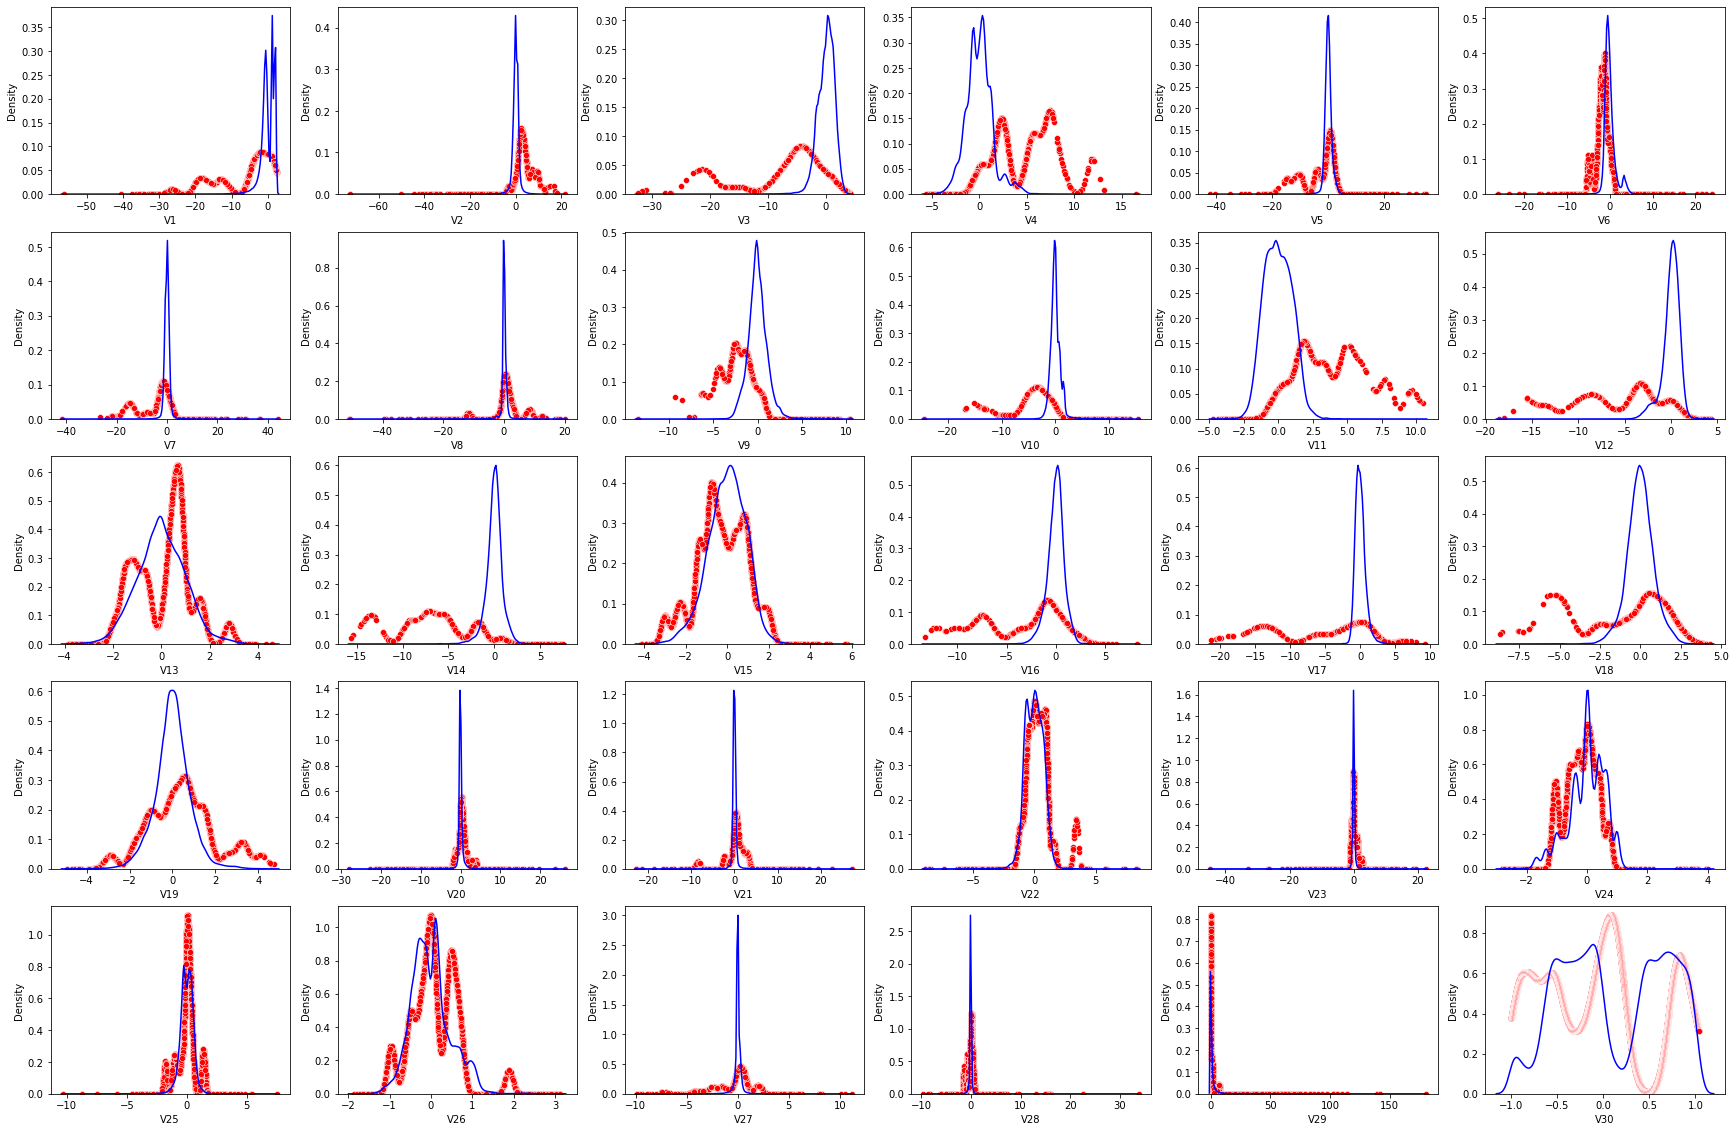

In [43]:
i = []
j = []

for (row,col),x in np.ndenumerate(arr) :
    i = i + [row]
    j = j + [col]

#확률밀도비교
#sharex (True일 경우 X축 공유)
import seaborn as sns

f, axes = plt.subplots(nrows,ncols, figsize=(30,20))

for col, i, j in zip(TrainData.drop(columns=['ID']).columns,i,j) :
    sns.kdeplot(TrainData[col],ax = axes[i,j], color = 'blue')
    sns.scatterplot(x=TrainData[col],y=train_pdf[col], ax = axes[i,j], color = 'red')
                 
plt.show()